<a href="https://colab.research.google.com/github/gourav10/Monocular_Depth_Estimation/blob/main/Monocular_Depth_Estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import sys
from urllib.request import FancyURLopener
import shutil
from PIL import Image
import numpy as np
import scipy.ndimage
import scipy.io as sio
import h5py

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import pprint

# 1. Download and Setup of Data

In [5]:
def download(url, destination, tmp_dir='/tmp'):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\rDownloading %s %.1f%%' % (url,
          float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    urlretrieve = FancyURLopener().retrieve
    if url.endswith('.zip'):
        local_zip_path = os.path.join(tmp_dir, 'datasets_download.zip')
        urlretrieve(url, local_zip_path, _progress)
        with zipfile.ZipFile(local_zip_path, "r") as zip_ref:
          zip_ref.extractall('/content/nyu_depth_v2/temp')
        os.remove(local_zip_path)
    else:
        urlretrieve(url, destination, _progress)

In [6]:
def dataset_download(url, destination):
    if not os.path.isfile(destination):
        download(url, destination)

In [7]:
NYUD_URL = 'http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat'
NYUD_SPLITS_URL = 'http://horatio.cs.nyu.edu/mit/silberman/indoor_seg_sup/splits.mat'

In [8]:
def save_nyu_depth_v2_dataset(source_dir, target_dir):
    if not os.path.isdir(source_dir):
        os.makedirs(source_dir)
    nyud_file_path = os.path.join(source_dir, 'nyu_depth_v2_labeled.mat')
    splits_file_path = os.path.join(source_dir, 'splits.mat')

    nyud_gdrive_file_path = '/content/gdrive/MyDrive/CS5330/depth_estimate/nyu_depth_v2_labeled.mat'
    splits_gdrivefile_path = '/content/gdrive/MyDrive/CS5330/depth_estimate/splits.mat'

    if(not os.path.isfile(nyud_gdrive_file_path) and not not os.path.isfile(splits_gdrivefile_path)):
      dataset_download(NYUD_URL, nyud_file_path)
      dataset_download(NYUD_SPLITS_URL, splits_file_path)
    else:
      return nyud_gdrive_file_path,splits_gdrivefile_path
      
    return nyud_file_path,splits_file_path

In [9]:
nyud_file_path,splits_file_path = save_nyu_depth_v2_dataset('/content/nyu_depth_v2','/content/nyu_depth_v2/labeled')
print("{}\n{}".format(nyud_file_path,splits_file_path))

/content/gdrive/MyDrive/CS5330/depth_estimate/nyu_depth_v2_labeled.mat
/content/gdrive/MyDrive/CS5330/depth_estimate/splits.mat


In [10]:
def get_dataset(source_dir, target_dir):
  print("Loading dataset: NYU Depth V2")
  nyud_dict = h5py.File(nyud_file_path, 'r')
  splits_dict = scipy.io.loadmat(splits_file_path)
  return nyud_dict, splits_dict

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from genericpath import isfile
target_dir = '/content/nyu_depth_v2/'
nyud_dict, splits_dict = get_dataset(nyud_file_path,target_dir)
pprint.pprint(nyud_dict.keys())
images = np.asarray(nyud_dict['images'])

Loading dataset: NYU Depth V2
<KeysViewHDF5 ['#refs#', '#subsystem#', 'accelData', 'depths', 'images', 'instances', 'labels', 'names', 'namesToIds', 'rawDepthFilenames', 'rawDepths', 'rawRgbFilenames', 'sceneTypes', 'scenes']>


In [13]:
depths = np.asarray(nyud_dict['depths'])

In [14]:
def get_train_validation_split(splits_dict,dataset_size = 300,split_percent = 0.2):
  indices = splits_dict['trainNdxs'][:, 0] - 1
  train_split_indicies = int(dataset_size*(1-split_percent))
  
  train_indices = splits_dict['trainNdxs'][:train_split_indicies, 0] - 1
  print("Training Data Size: ",len(indices[:train_split_indicies]))
  
  validation_indices = splits_dict['trainNdxs'][train_split_indicies:dataset_size, 0] - 1
  print("Validation Data Size: ",len(validation_indices))
  
  test_indices = splits_dict['testNdxs'][:, 0] - 1
  print("Testing Data Size: ",len(test_indices))
  return train_indices, validation_indices,test_indices

In [15]:
train_indices, validation_indices,test_indices = get_train_validation_split(splits_dict,dataset_size = 400,split_percent = 0.2)

Training Data Size:  320
Validation Data Size:  80
Testing Data Size:  654


In [16]:
def get_images_depths(images,depths, train_indices):
  images_train = np.take(images, train_indices, axis=0)
  images_train = images_train.swapaxes(2, 3)
  print(images_train.shape)

  depths_train = np.expand_dims(depths.swapaxes(1, 2), 1)
  depths_train = np.take(depths_train, train_indices, axis=0)
  print(depths_train.shape)
  return images_train,depths_train

train_images, train_depths = get_images_depths(images,depths,train_indices)
validation_images, validation_depths = get_images_depths(images,depths,validation_indices)
test_images,test_depths = get_images_depths(images,depths,test_indices)


(320, 3, 480, 640)
(320, 1, 480, 640)
(80, 3, 480, 640)
(80, 1, 480, 640)
(654, 3, 480, 640)
(654, 1, 480, 640)


# 2. Visualization of Training and Test Data

**Training Data Visualization**

320
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)


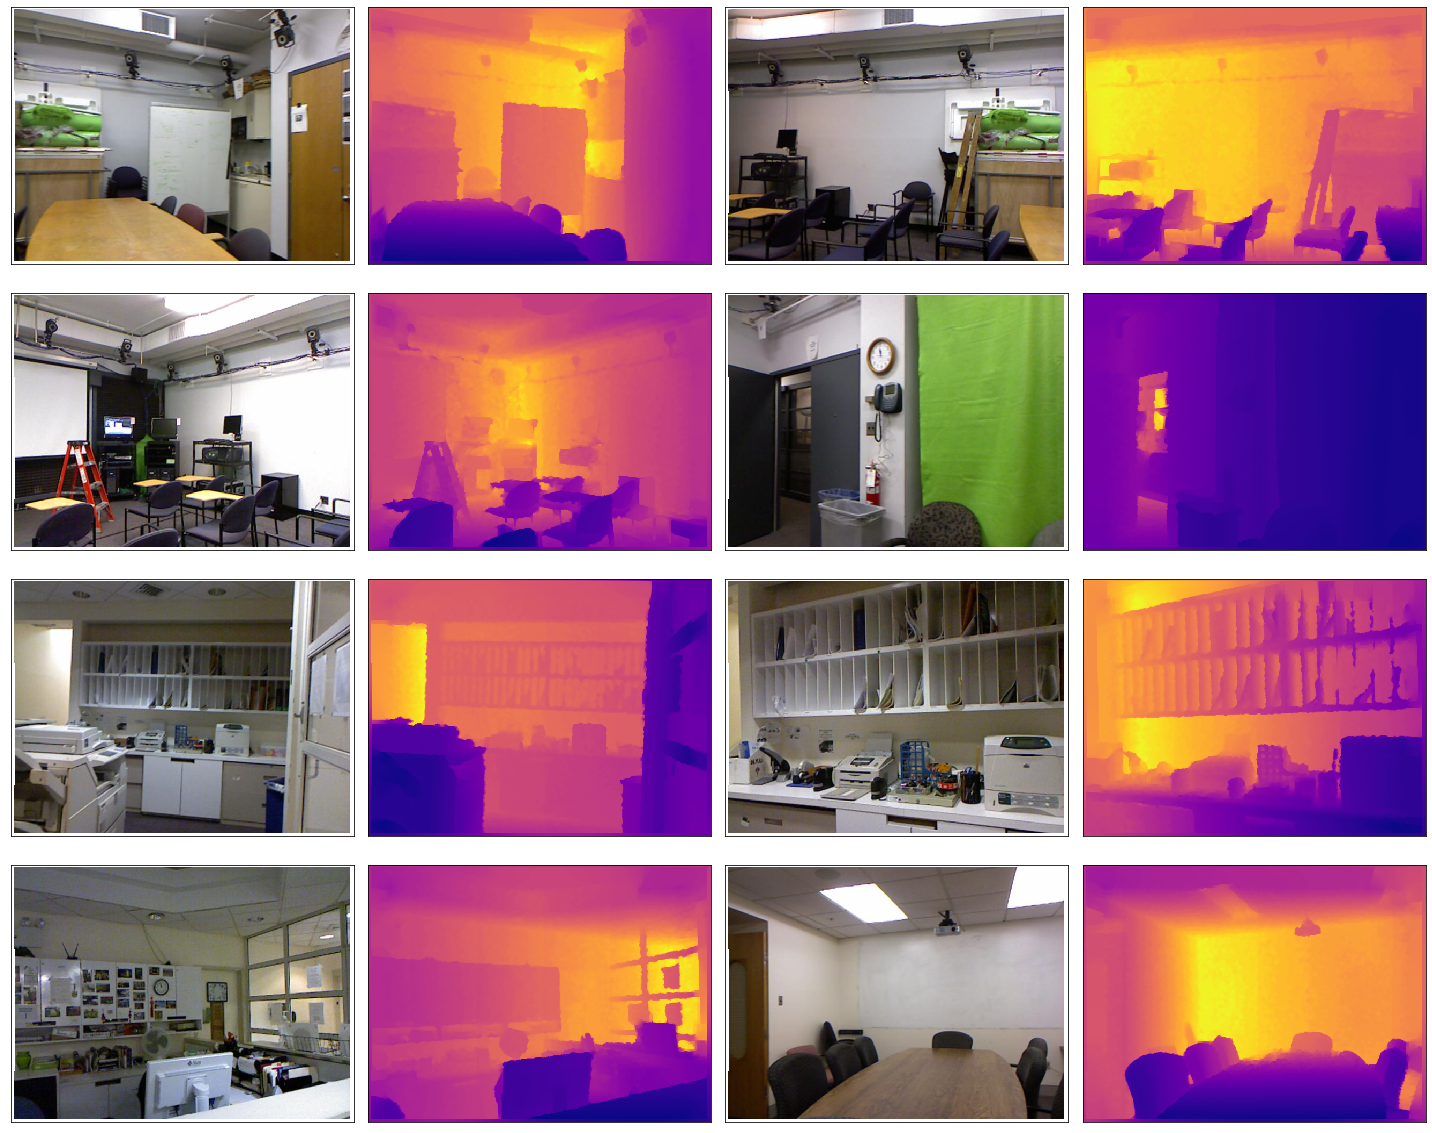

In [17]:
print(len(train_images))
fig = plt.figure(figsize=(20,20))
k=1
for sample_idx in range(8):
  print("Data Type: {}, Pre-Transpose: {}".format(type(train_images[sample_idx]),train_images[sample_idx].shape))
  plt.subplot(5,4, k)
  plt.imshow(train_images[train_indices[sample_idx]].transpose(1,2,0),interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
  plt.subplot(5,4, k)
  plt.imshow(train_depths[train_indices[sample_idx]][0],cmap='plasma',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
fig.tight_layout()
fig.show()

**Test Data Visualization**

654
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)
Data Type: <class 'numpy.ndarray'>, Pre-Transpose: (3, 480, 640)


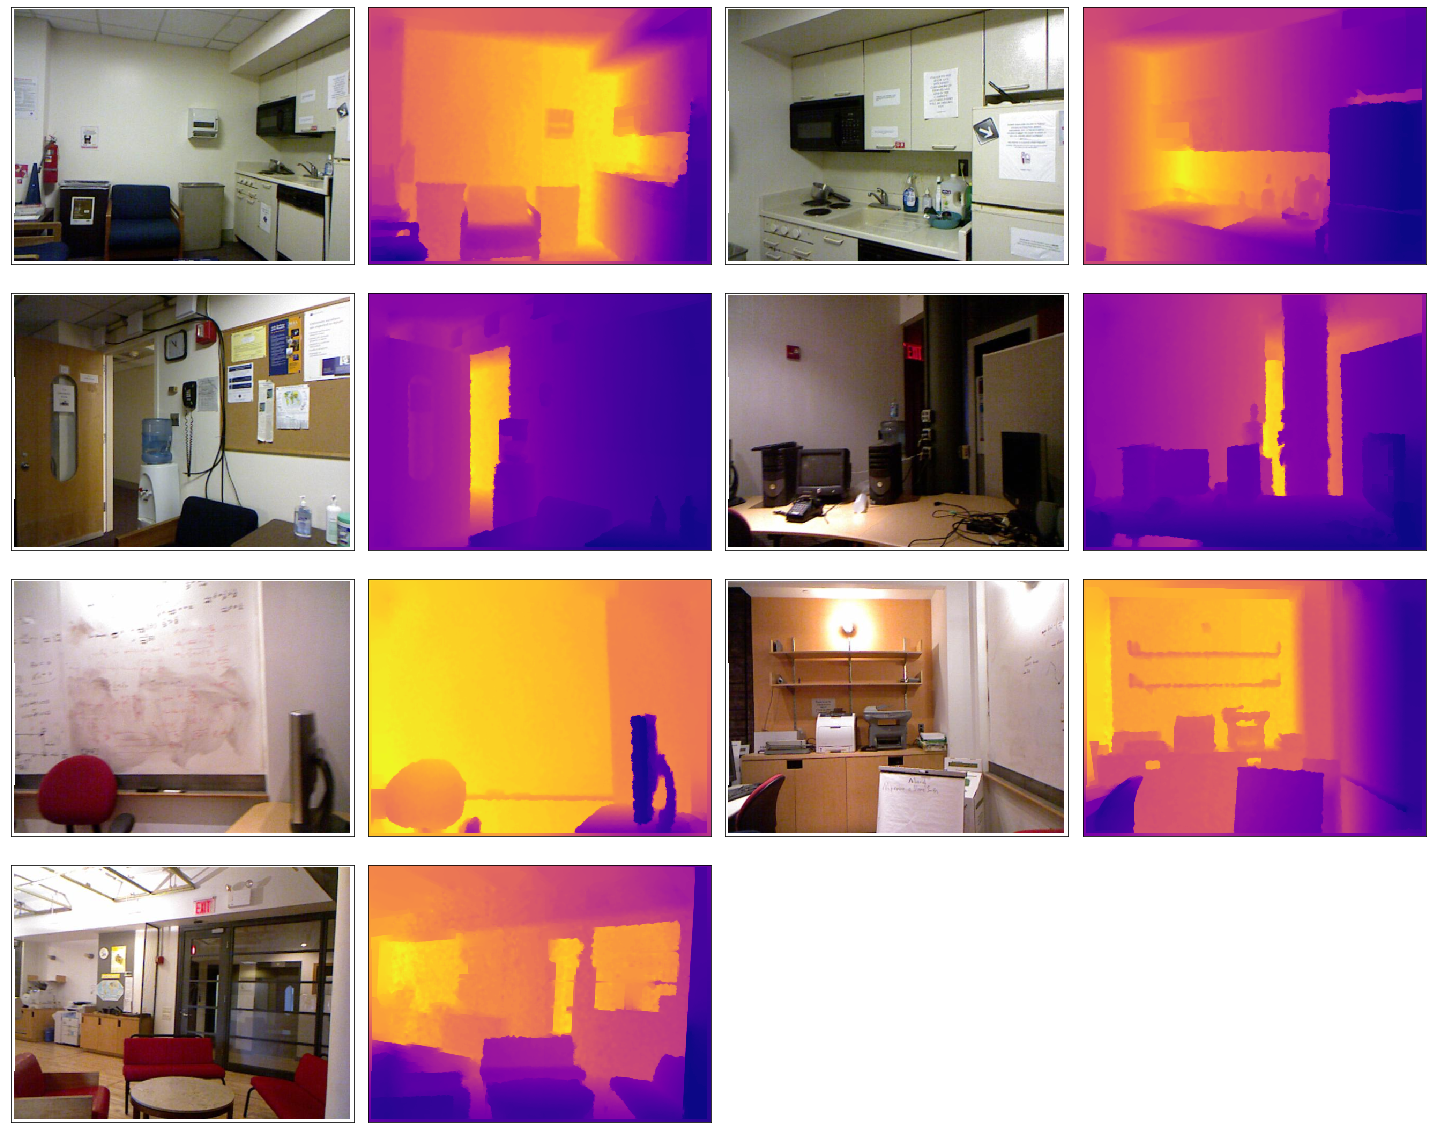

In [18]:
print(len(test_images))
fig = plt.figure(figsize=(20,20))
k=1
for sample_idx in range(7):
  print("Data Type: {}, Pre-Transpose: {}".format(type(test_images[sample_idx]),test_images[sample_idx].shape))
  plt.subplot(5,4, k)
  plt.imshow(test_images[test_indices[sample_idx]].transpose(1,2,0),cmap='gray',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
  plt.subplot(5,4, k)
  plt.imshow(test_depths[test_indices[sample_idx]][0],cmap='plasma',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
fig.tight_layout()
fig.show()

# 3. Generate Dataset and Dataloader

In [19]:
import torchvision, torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms as T
from torch import optim
import copy

In [20]:
class NYUDepthDataset(torch.utils.data.Dataset):
  def __init__(self,images,indices,depths,transform=None,train=True):
    self.images = images
    self.indicies = indices
    self.maps = depths
    self.transform = transform

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self,index):
    image = torch.from_numpy(self.images[index]/255).float()
    if(self.transform is not None):
      image = self.transform(image)
    dmap = torch.from_numpy(self.maps[index]).float()
    if(self.transform is not None):
      dmap = self.transform(dmap)
    return image,dmap

In [21]:
from torchvision.transforms import transforms
train_dataset = NYUDepthDataset(train_images,train_indices,train_depths,transform = transforms.Compose([T.Resize((320,320))]))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=4,shuffle=False)


validation_dataset = NYUDepthDataset(validation_images,validation_indices,validation_depths,transform = transforms.Compose([T.Resize((320,320))]))
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=10,shuffle=False)

test_dataset = NYUDepthDataset(test_images,test_indices,test_depths,transform = transforms.Compose([T.Resize((320,320))]))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=10,shuffle=True)

In [22]:
counter=0
for batch_idx,(features,targets) in enumerate(train_loader):
  counter+=1
print("Total Number of Batches: ",counter)

Total Number of Batches:  80


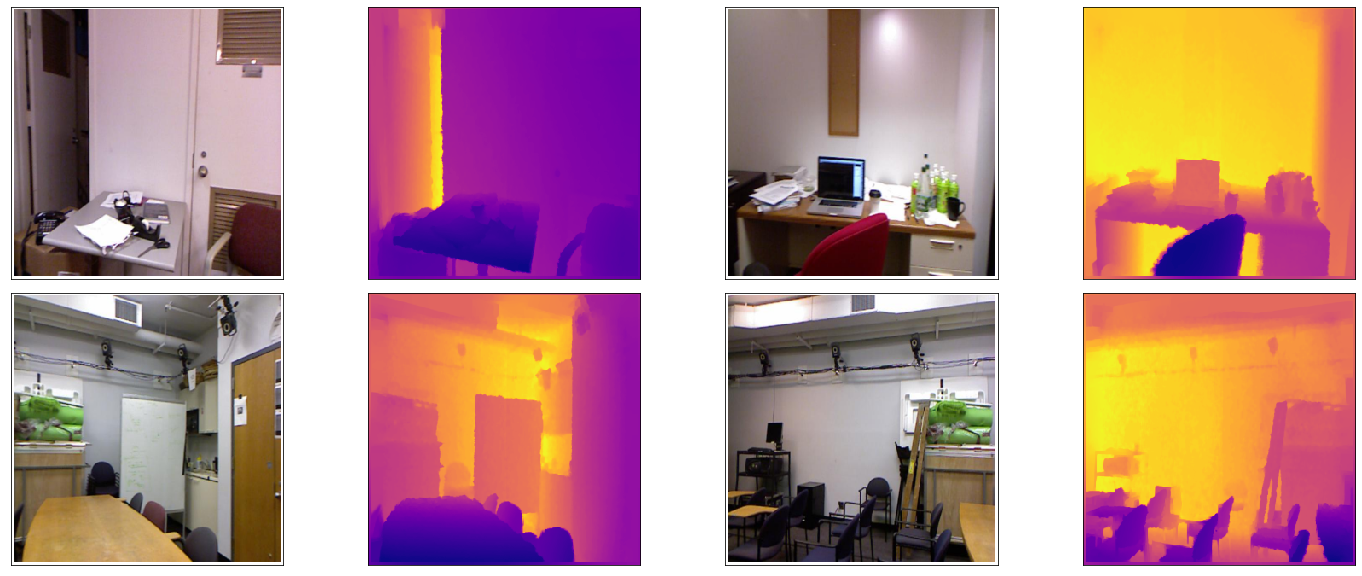

In [23]:
examples = enumerate(train_loader)
batch_idx, (example_data,example_targets) = next(examples)
k=1
fig = plt.figure(figsize=(20,20))
for idx in range(4):
  plt.subplot(5,4, k)
  img = example_data.numpy()
  plt.imshow(img[idx].transpose(1,2,0),cmap='gray',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
  plt.subplot(5,4, k)
  plt.imshow(example_targets[idx][0],cmap='plasma',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
fig.tight_layout()
fig.show()

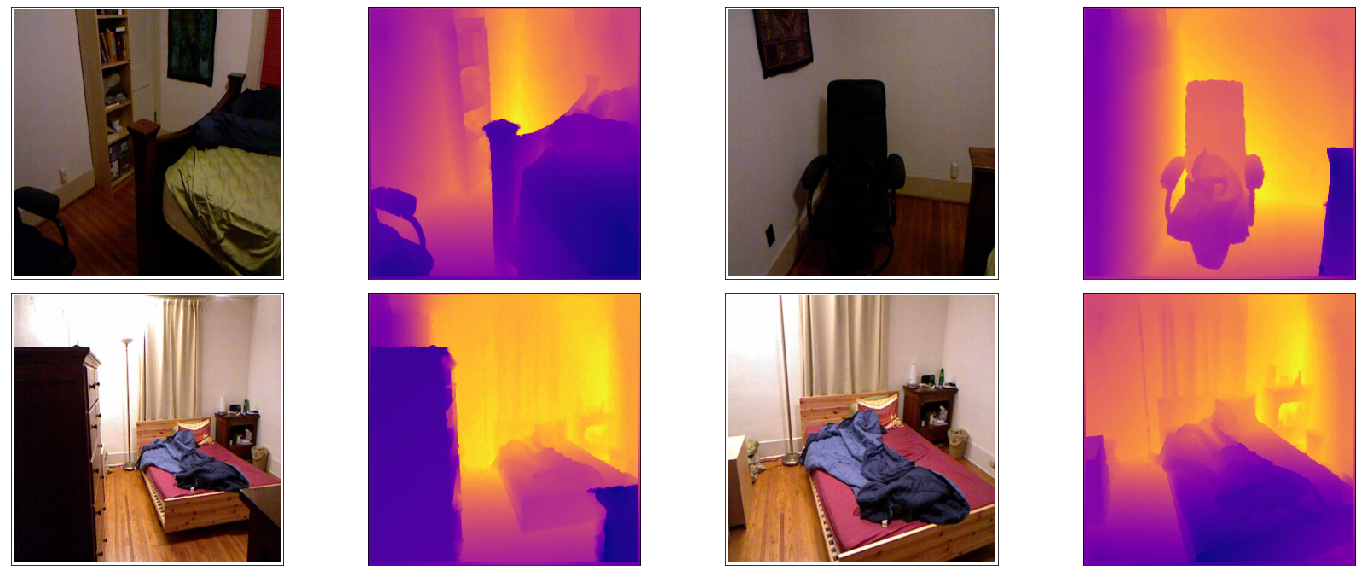

In [24]:
examples = enumerate(validation_loader)
batch_idx, (example_data,example_targets) = next(examples)
k=1
fig = plt.figure(figsize=(20,20))
for idx in range(4):
  plt.subplot(5,4, k)
  img = example_data.numpy()
  plt.imshow(img[idx].transpose(1,2,0),cmap='gray',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
  plt.subplot(5,4, k)
  plt.imshow(example_targets[idx][0],cmap='plasma',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
fig.tight_layout()
fig.show()

# Building U-Net Model

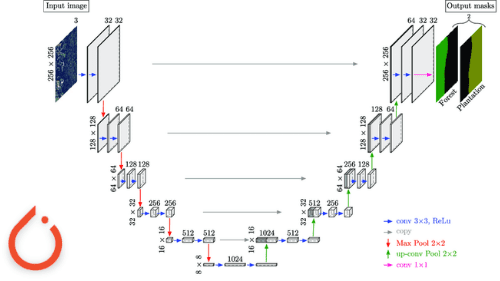

In [25]:
def double_conv(in_c,out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c,out_c,kernel_size=3,padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c,out_c,kernel_size=3,padding=1),
      nn.ReLU(inplace=True)
  )
  return conv

In [26]:
def crop_image(tensor,target_tensor):
  target_size = target_tensor.size()[2]
  tensor_size = tensor.size()[2]
  delta = tensor_size-target_size
  delta = delta//2
  return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta]

In [27]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet,self).__init__()
    self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2,stride=2)
    self.down_conv_1 = double_conv(3,64)
    self.down_conv_2 = double_conv(64,128)
    self.down_conv_3 = double_conv(128,256)
    self.down_conv_4 = double_conv(256,512)
    self.down_conv_5 = double_conv(512,1024)

    self.up_trans_1 = nn.ConvTranspose2d(
        in_channels=1024,
        out_channels=512,
        kernel_size=2,
        stride=2)
    
    self.up_conv_1 = double_conv(1024,512)

    self.up_trans_2 = nn.ConvTranspose2d(
        in_channels=512,
        out_channels=256,
        kernel_size=2,
        stride=2)
    
    self.up_conv_2 = double_conv(512,256)

    self.up_trans_3 = nn.ConvTranspose2d(
        in_channels=256,
        out_channels=128,
        kernel_size=2,
        stride=2)
    
    self.up_conv_3 = double_conv(256,128)

    self.up_trans_4 = nn.ConvTranspose2d(
        in_channels=128,
        out_channels=64,
        kernel_size=2,
        stride=2)
    
    self.up_conv_4 = double_conv(128,64)

    self.out = nn.Conv2d(
        in_channels=64,
        out_channels=1,
        kernel_size=1
    )

  def forward(self,image):
    #encoder
    x1 = self.down_conv_1(image) #
    x2 = self.max_pool_2x2(x1)
    x3 = self.down_conv_2(x2) #
    x4 = self.max_pool_2x2(x3) 
    x5 = self.down_conv_3(x4) # 
    x6 = self.max_pool_2x2(x5) 
    x7 = self.down_conv_4(x6) #
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv_5(x8)
    x10 = self.max_pool_2x2(x9)
    
    #decoder
    x = self.up_trans_1(x9)
    y = crop_image(x7,x)
    x = self.up_conv_1(torch.cat([x,y],1))

    x = self.up_trans_2(x)
    y = crop_image(x5,x)
    x = self.up_conv_2(torch.cat([x,y],1))

    x = self.up_trans_3(x)
    y = crop_image(x3,x)
    x = self.up_conv_3(torch.cat([x,y],1))

    x = self.up_trans_4(x)
    y = crop_image(x1,x)
    x = self.up_conv_4(torch.cat([x,y],1))
    x = self.out(x)
    return x

In [28]:
#Run Summary
model = UNet()
summary(model.to('cuda'),(3,320,320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           1,792
              ReLU-2         [-1, 64, 320, 320]               0
            Conv2d-3         [-1, 64, 320, 320]          36,928
              ReLU-4         [-1, 64, 320, 320]               0
         MaxPool2d-5         [-1, 64, 160, 160]               0
            Conv2d-6        [-1, 128, 160, 160]          73,856
              ReLU-7        [-1, 128, 160, 160]               0
            Conv2d-8        [-1, 128, 160, 160]         147,584
              ReLU-9        [-1, 128, 160, 160]               0
        MaxPool2d-10          [-1, 128, 80, 80]               0
           Conv2d-11          [-1, 256, 80, 80]         295,168
             ReLU-12          [-1, 256, 80, 80]               0
           Conv2d-13          [-1, 256, 80, 80]         590,080
             ReLU-14          [-1, 256,

**Model Output before Training**

torch.Size([4, 1, 320, 320])
torch.Size([4, 1, 320, 320])
torch.Size([4, 1, 320, 320])
torch.Size([4, 1, 320, 320])


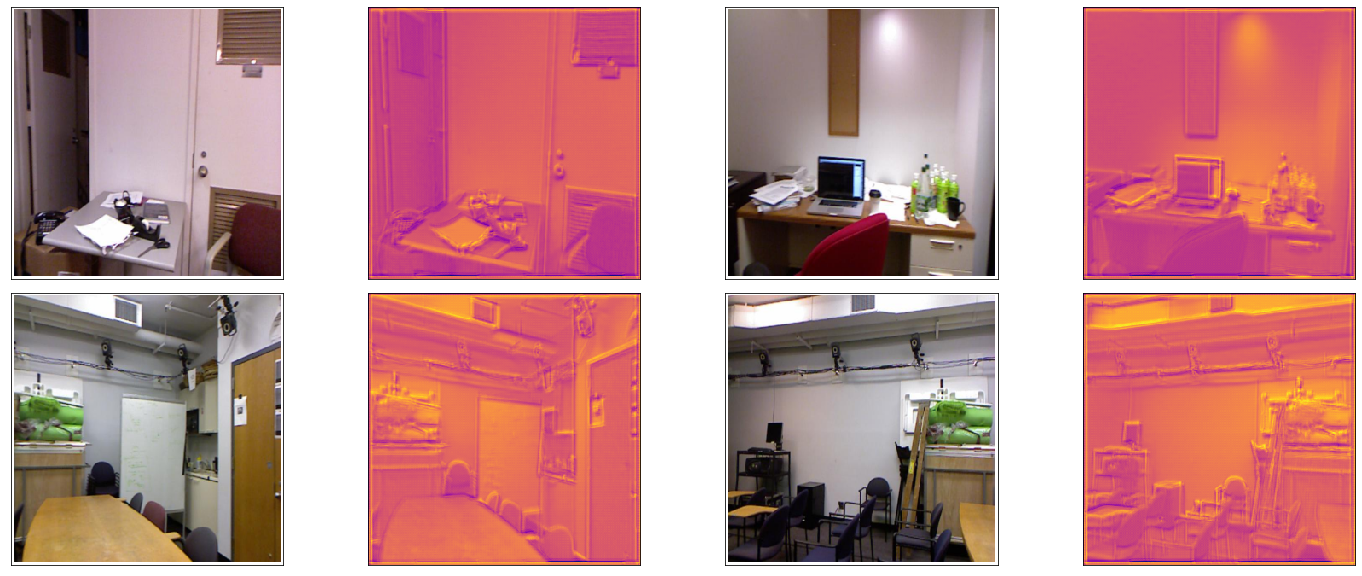

In [29]:
model.to('cpu')
examples = enumerate(train_loader)
batch_idx, (example_data,example_targets) = next(examples)
output = model(example_data)
k=1
fig = plt.figure(figsize=(20,20))
for idx in range(4):
  plt.subplot(5,4, k)
  image_num = example_data.numpy()
  plt.imshow(image_num[idx].transpose(1,2,0),cmap='gray',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
  plt.subplot(5,4, k)
  output_num = output.to('cpu').detach().numpy()
  print(output.shape)
  plt.imshow(output_num[idx][0],cmap='plasma',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
fig.tight_layout()
fig.show()

# Train and Validate Model

---



---



In [30]:
def get_device():
    if(torch.cuda.is_available()):
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [31]:
def train(model,data_loader, optimizer, criterion, device,epoch):
    model.to(device)
    model.train()
    correct = 0
    total = 0
    num_batches = 0
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (feature_data,labels) in enumerate(data_loader):
        feature_data = feature_data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(feature_data)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)        
        train_loss += loss.item()
        num_batches+=1
    return train_loss/num_batches

In [32]:
def validate(model,data_loader, optimizer, criterion, device):
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    num_batches = 0
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx,(feature_data,labels) in enumerate(data_loader):
        feature_data = feature_data.to(device)
        labels = labels.to(device)
        output = model(feature_data)
        loss = criterion(output,labels)
        total += labels.size(0)
        val_loss += loss.item()
        num_batches+=1
    return val_loss/num_batches

In [33]:
def plot_loss(num_epochs,train_losses,test_losses):
    
    # Using Numpy to create an array X
    X = range(num_epochs)
    
    # Assign variables to the y axis part of the curve
    y = train_losses
    z = test_losses
    
    plt.plot(X,y,color='blue')
    plt.plot(X,z,color='red')
    plt.legend(['Train Loss','Validation Loss'],loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Training and Validation Losses")

In [34]:
from torch._C import device
def fit_model(model,num_epochs,train_dl,validation_dl):
    test_losses=[]
    test_accuracies = []
    train_losses=[]
    train_accuracies=[]
    
    min_loss=float('inf')
    min_train_loss = float('inf')
    best_model = model
    learn_rate = 0.001
    
    device = get_device()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    for epoch in range(num_epochs):
        train_loss = train(model,train_dl, optimizer, criterion, device,epoch)
        test_loss = validate(model,validation_dl, optimizer, criterion, device)
        
        # if(num_epochs%10==0):
        #   if(epoch%10==0):
        #     print("Epoch:{}, Train Loss: {:.4f}, Valid Loss: {:.4f}".format(epoch,train_loss,test_loss))
        # else:
        print("Epoch:{}, Train Loss: {:.4f}, Valid Loss: {:.4f}".format(epoch,train_loss,test_loss))

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if(min_loss>test_loss):
            best_model = copy.deepcopy(model)
            min_loss = test_loss
            min_train_loss = train_loss
            print("Saving Best Model with Min Validation Loss: ", min_loss)
    
    plot_loss(num_epochs,train_losses,test_losses)
    return best_model,min_loss,min_train_loss

**Initialize Model with default parameters and epochs**

---

Epoch:0, Train Loss: 20670.0419, Valid Loss: 5.7530
Saving Best Model with Min Validation Loss:  5.752995550632477
Epoch:1, Train Loss: 8.5872, Valid Loss: 1.8395
Saving Best Model with Min Validation Loss:  1.8394531160593033
Epoch:2, Train Loss: 7.7591, Valid Loss: 1.6626
Saving Best Model with Min Validation Loss:  1.6625551134347916
Epoch:3, Train Loss: 2.9021, Valid Loss: 1.4777
Saving Best Model with Min Validation Loss:  1.4776637181639671
Epoch:4, Train Loss: 2.5834, Valid Loss: 1.4751
Saving Best Model with Min Validation Loss:  1.4751170054078102


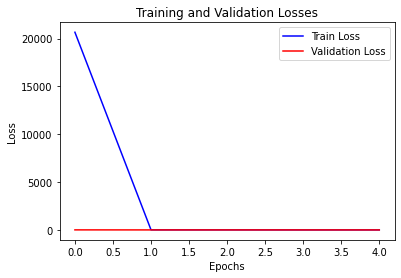

In [35]:
num_epochs = 5
model = UNet()
best_model,train_loss,val_loss = fit_model(model,num_epochs,train_loader,validation_loader)

In [1]:
best_model.to('cpu')
examples = enumerate(test_loader)
batch_idx, (example_data,example_targets) = next(examples)
output = best_model(example_data)
k=1
fig = plt.figure(figsize=(20,20))
for idx in range(4):
  plt.subplot(5,4, k)
  image_num = example_data.numpy()
  plt.imshow(image_num[idx].transpose(1,2,0),cmap='gray',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
  plt.subplot(5,4, k)
  output_num = output.to('cpu').detach().numpy()
  print(output.shape)
  plt.imshow(output_num[idx][0],cmap='plasma',interpolation='none')
  k+=1
  plt.xticks([])
  plt.yticks([])
fig.tight_layout()
fig.show()

NameError: ignored